In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# ----------------- LOAD DATA -----------------
import pandas as pd
import numpy as np

# Load data
train_df = pd.read_csv('/kaggle/input/mlpr-data-split/train.csv')
test_df = pd.read_csv('/kaggle/input/mlpr-data-split/test.csv')

# Function to split and process a DataFrame
def process_df(df):
    # Create storm lagged severity-based DataFrames
    df_low = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 0)].copy()
    df_medium = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 1)].copy()
    df_high = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 2)].copy()

    # Add is_outage flag
    for sub_df in [df_low, df_medium, df_high]:
        sub_df['is_outage'] = (sub_df['customers_out'] > 0).astype(int)

    # Process non-storm rows
    non_storm_data = df[df['is_storm_lagged'] == 0].copy()
    non_storm_data['is_outage'] = 0
    non_storm_data['severity_class'] = 10  # Placeholder

    # Shuffle and split non-storm rows
    non_storm_split = np.array_split(non_storm_data.sample(frac=1, random_state=42), 3)
    non_storm_low, non_storm_medium, non_storm_high = non_storm_split

    # Augment original DataFrames
    df_low = pd.concat([df_low, non_storm_low], ignore_index=True)
    df_medium = pd.concat([df_medium, non_storm_medium], ignore_index=True)
    df_high = pd.concat([df_high, non_storm_high], ignore_index=True)

    return df_low, df_medium, df_high

# Process both train and test DataFrames
train_low, train_medium, train_high = process_df(train_df)
test_low, test_medium, test_high = process_df(test_df)

outage_features = [
    'tmin', 'tmax', 'tavg', 'ppt',
    'has_tornado', 'has_hail', 'has_flood', 'has_wind', 'has_tree',
    'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'duration_hours',
    'desc_word_count', 'desc_char_count'
]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Low Severity

[LightGBM] [Info] Number of positive: 22426, number of negative: 24427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 46853, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478646 -> initscore=-0.085468
[LightGBM] [Info] Start training from score -0.085468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

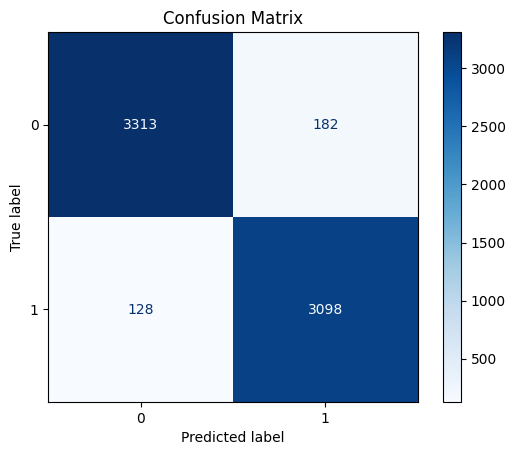

['/kaggle/working/low_severity_scaler.pkl']

In [4]:
import lightgbm as lgb

# ----------------- PREPARE FEATURES -----------------
X_train = train_low[outage_features]
y_train = train_low['is_outage']

X_test = test_low[outage_features]
y_test = test_low['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- TRAIN MODEL -----------------
lgb_model = lgb.LGBMClassifier(
    n_estimators = 319,
    learning_rate = 0.047847333909262976,
    num_leaves = 281,
    max_depth = 20,
    min_child_samples = 22,
    subsample = 0.527136639688917,
    colsample_bytree = 0.8326768083509417,
    random_state = 42
)
lgb_model.fit(X_train_scaled, y_train)

# ----------------- EVALUATE -----------------
y_pred = lgb_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ----------------- EXPORT MODEL AND SCALER -----------------
joblib.dump(lgb_model, '/kaggle/working/low_severity_lgm_model.pkl')
joblib.dump(scaler, '/kaggle/working/low_severity_scaler.pkl')

# Medium Severity

Accuracy: 0.9260
Precision (weighted): 0.9264
Recall (weighted): 0.9260
F1 Score (weighted): 0.9261


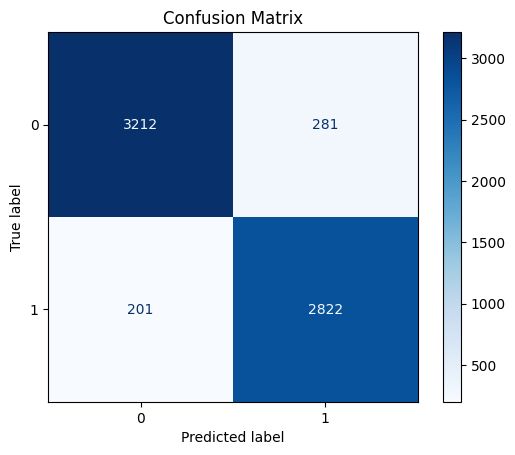

['/kaggle/working/medium_severity_scaler.pkl']

In [3]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# ----------------- PREPARE FEATURES -----------------
outage_features = [
    'tmin', 'tmax', 'tavg', 'ppt',
    'has_tornado', 'has_hail', 'has_flood', 'has_wind', 'has_tree',
    'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'duration_hours',
    'desc_word_count', 'desc_char_count'
]

X_train = train_medium[outage_features]
y_train = train_medium['is_outage']

X_test = test_medium[outage_features]
y_test = test_medium['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- TRAIN MODEL -----------------
rf_model = RandomForestClassifier(
    n_estimators=201,
    max_depth=38,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# ----------------- EVALUATE -----------------
y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ----------------- EXPORT MODEL AND SCALER -----------------
joblib.dump(rf_model, '/kaggle/working/medium_severity_rf_model.pkl')
joblib.dump(scaler, '/kaggle/working/medium_severity_scaler.pkl')

# High Severity

2025-05-02 10:16:50.812590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746181011.076007      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746181011.149589      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-02 10:17:07.593575: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8685
Precision (weighted): 0.8759
Recall (weighted): 0.8685
F1 Score (weighted): 0.8683


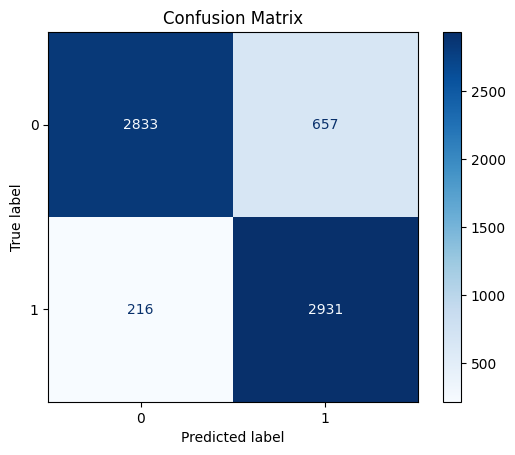

['/kaggle/working/high_severity_scaler.pkl']

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ----------------- PREPARE FEATURES -----------------
X_train = train_high[outage_features]
y_train = train_high['is_outage']

X_test = test_high[outage_features]
y_test = test_high['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- TRAIN MODEL -----------------
# Optimized hyperparameters from Optuna
n_units = [80, 112, 96]
dropout_rate = 0.1677425146431672
learning_rate = 0.001715383587455835
batch_size = 64

# Build optimized model
model = Sequential()
model.add(Dense(n_units[0], activation='relu', input_shape=(len(outage_features),)))
model.add(Dropout(dropout_rate))
model.add(Dense(n_units[1], activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(n_units[2], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)

# ----------------- EVALUATE -----------------
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ----------------- EXPORT MODEL -----------------
joblib.dump(model, '/kaggle/working/high_severity_fnn_model.pkl')
joblib.dump(scaler, '/kaggle/working/high_severity_scaler.pkl')